<a href="https://colab.research.google.com/github/PrabhuKiran8790/NLP/blob/main/NLP_Project_BI_LSTM_BERT_EMBEDDINGS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download Preprocessed Data
- data preprocessing notebook can be found <a href="https://github.com/PrabhuKiran8790/NLP/blob/main/final-project/bi_lstm_nlp_data_preprocessing.ipynb">here</s>

In [1]:
!gdown 1Umtz-Un9pXTgdPrN22mZiw-qCHXGd7ls

Downloading...
From: https://drive.google.com/uc?id=1Umtz-Un9pXTgdPrN22mZiw-qCHXGd7ls
To: /content/df_cleaned_train_test_val_.pkl
100% 2.38M/2.38M [00:00<00:00, 222MB/s]


In [2]:
import pickle

cleaned_data = None
with open('/content/df_cleaned_train_test_val_.pkl', 'rb') as f:
    cleaned_data = pickle.load(f)

In [3]:
df_cleaned_train = cleaned_data['df_cleaned_train']
df_test = cleaned_data['df_test']
df_val = cleaned_data['df_val']

In [4]:
import pandas as pd
import numpy as np
from keras.preprocessing.text import Tokenizer

In [5]:
!pip install --upgrade tensorflow_hub -q

In [6]:
df_train_inputs = df_cleaned_train.Input.tolist()

# BERT
- BERT for embedding

In [7]:
import tensorflow_hub as hub

model = hub.KerasLayer("https://tfhub.dev/google/nnlm-en-dim128/2")
embeddings = model(df_train_inputs)
print(embeddings.shape)

(16000, 128)


In [8]:
from keras.utils import to_categorical
y_train = to_categorical(df_cleaned_train.Sentiment.values)
y_test = to_categorical(df_test.Sentiment.values)
y_val = to_categorical(df_val.Sentiment.values)

In [9]:
num_words = 16000
tokenizer = Tokenizer(num_words,lower=True)
df_total = pd.concat([df_cleaned_train['Input'], df_test.Input], axis = 0)
tokenizer.fit_on_texts(df_total)

In [10]:
from keras_preprocessing.sequence import pad_sequences

X_train = tokenizer.texts_to_sequences(df_cleaned_train['Input']) # texts -> numeric sequences 
X_train_pad = pad_sequences(X_train, maxlen=300, padding='post') # length of all numeric sequences equal

X_test = tokenizer.texts_to_sequences(df_test.Input)
X_test_pad = pad_sequences(X_test, maxlen = 300, padding = 'post')

X_val = tokenizer.texts_to_sequences(df_val.Input)
X_val_pad = pad_sequences(X_val, maxlen = 300, padding = 'post')

In [11]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, LSTM, Embedding,Bidirectional
import tensorflow as tf
# tf.compat.v1.keras.layers.CuDNNLSTM
from tensorflow.compat.v1.keras.layers import CuDNNLSTM,CuDNNGRU
from tensorflow.keras.layers import Dropout

# Model Architecture

In [13]:
EMBEDDING_DIM = 128 # this means the embedding layer will create  a vector in 128 dimension

model = Sequential()
model.add(Embedding(input_dim = num_words, # the whole vocabulary size 
                    output_dim = EMBEDDING_DIM, # vector space dimension
                    input_length= X_train_pad.shape[1], # max_len of text sequence
                    weights = [embeddings],trainable = False))

model.add(Dropout(0.2))
model.add(Bidirectional(CuDNNLSTM(100,return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(CuDNNLSTM(200,return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(CuDNNLSTM(100,return_sequences=False)))
model.add(Dense(6, activation = 'softmax'))


model.compile(loss = 'categorical_crossentropy',
              optimizer = 'adam',
              metrics = 'accuracy')

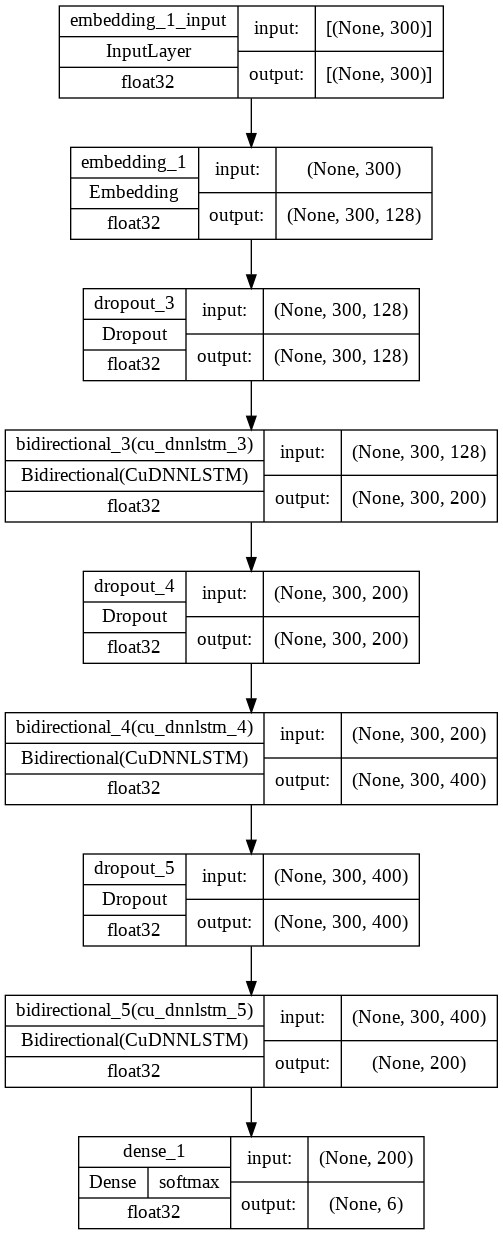

In [14]:
tf.keras.utils.plot_model(model, show_shapes=True, show_dtype=True, show_layer_activations=True)

In [15]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 5)
mc = ModelCheckpoint('./model{epoch:02d}.h5', monitor = 'val_accuracy', mode = 'max', verbose = 1, save_best_only = True)

In [16]:
history_embedding = model.fit(X_train_pad,
                              y_train,
                              epochs = 50,
                              batch_size = 128,
                              validation_data=(X_val_pad, y_val),
                              verbose = 1,
                              callbacks=[es, mc])

Epoch 1/50
125/125 [==============================] - ETA: 0s - loss: 1.5802 - accuracy: 0.3382
Epoch 1: val_accuracy improved from -inf to 0.35350, saving model to ./model01.h5
125/125 [==============================] - 32s 186ms/step - loss: 1.5802 - accuracy: 0.3382 - val_loss: 1.5800 - val_accuracy: 0.3535
Epoch 2/50
125/125 [==============================] - ETA: 0s - loss: 1.5708 - accuracy: 0.3451
Epoch 2: val_accuracy did not improve from 0.35350
125/125 [==============================] - 22s 178ms/step - loss: 1.5708 - accuracy: 0.3451 - val_loss: 1.5714 - val_accuracy: 0.3525
Epoch 3/50
125/125 [==============================] - ETA: 0s - loss: 1.5636 - accuracy: 0.3519
Epoch 3: val_accuracy did not improve from 0.35350
125/125 [==============================] - 22s 180ms/step - loss: 1.5636 - accuracy: 0.3519 - val_loss: 1.5780 - val_accuracy: 0.3200
Epoch 4/50
125/125 [==============================] - ETA: 0s - loss: 1.5581 - accuracy: 0.3517
Epoch 4: val_accuracy did not 

# Model Performance Visualization

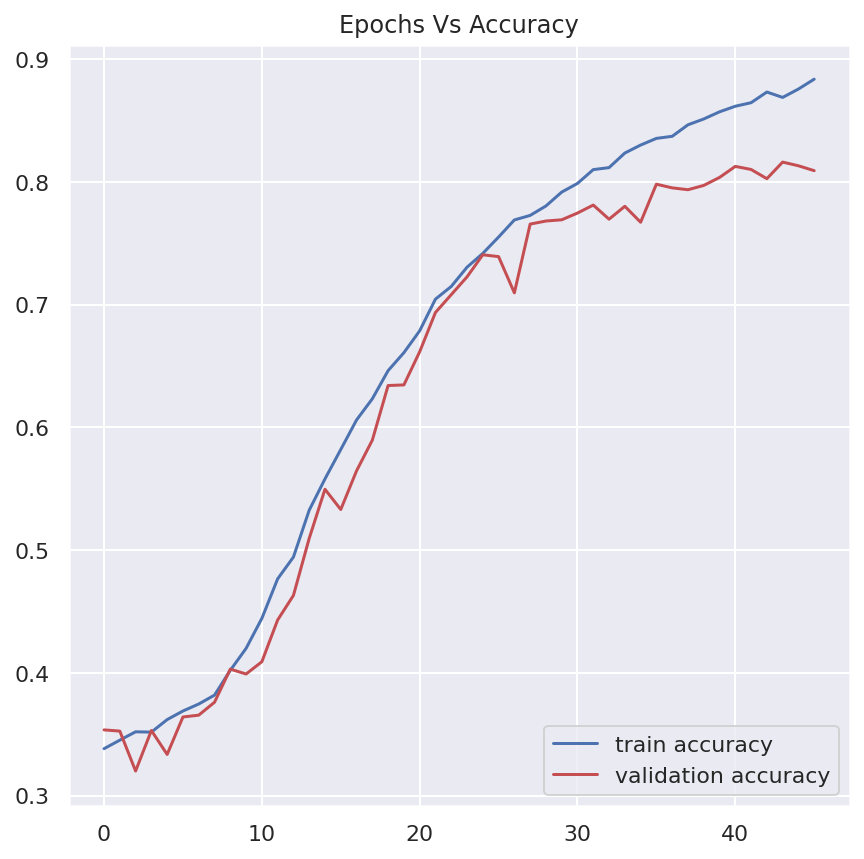

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%config InlineBackend.figure_format = 'retina'

plt.rcParams["figure.figsize"] = (7,7)
plt.plot(history_embedding.history['accuracy'],c='b',label='train accuracy')
plt.plot(history_embedding.history['val_accuracy'],c='r',label='validation accuracy')
plt.legend(loc='lower right')
plt.title("Epochs Vs Accuracy")
plt.show()

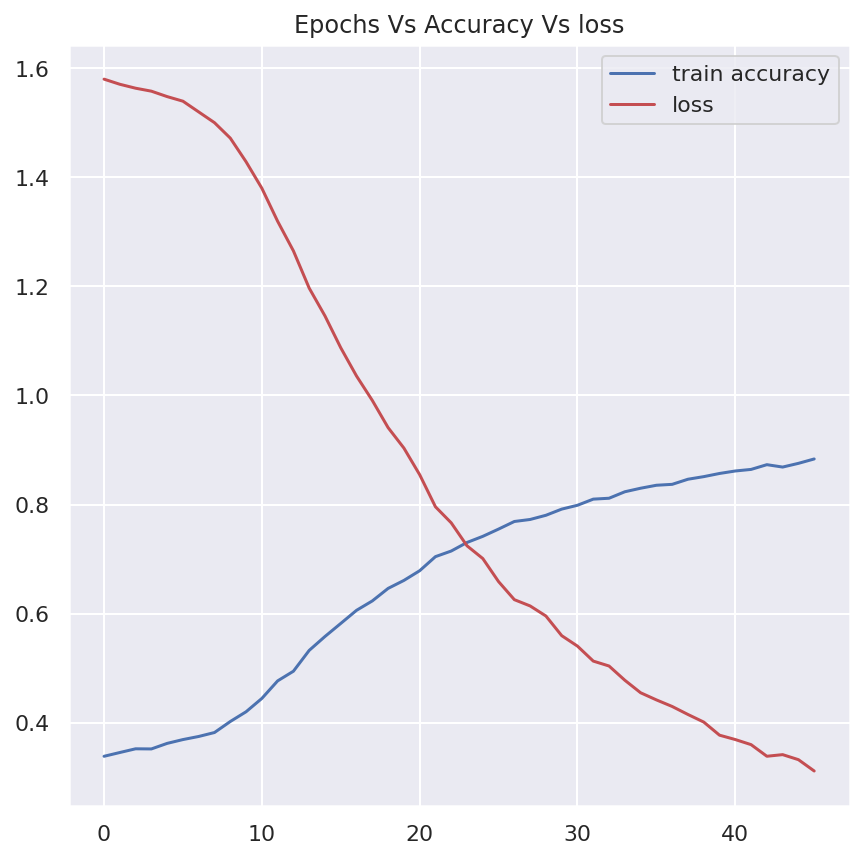

In [18]:
plt.rcParams["figure.figsize"] = (7,7)
plt.plot(history_embedding.history['accuracy'],c='b',label='train accuracy')
plt.plot(history_embedding.history['loss'],c='r',label='loss')
plt.legend(loc='upper right')
plt.title("Epochs Vs Accuracy Vs loss")
plt.show()

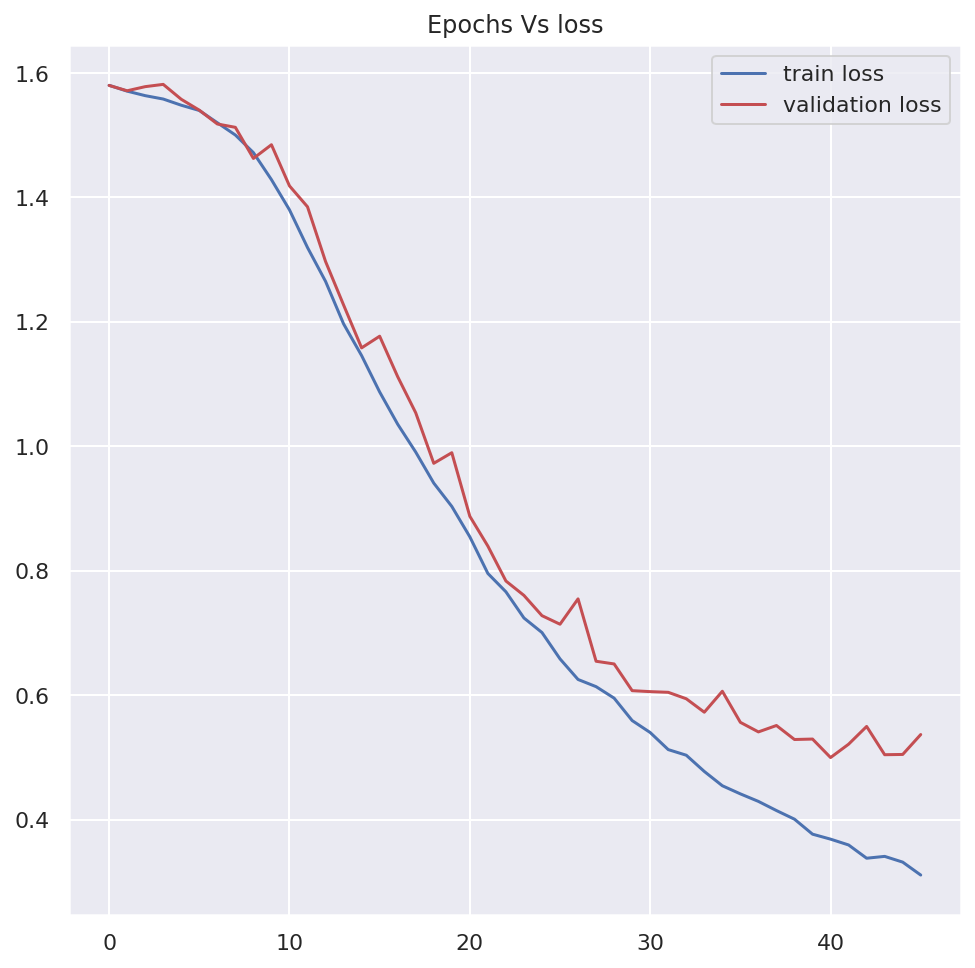

In [19]:
plt.rcParams["figure.figsize"] = (8,8)
plt.plot(history_embedding.history['loss'],c='b',label='train loss')
plt.plot(history_embedding.history['val_loss'],c='r',label='validation loss')
plt.legend(loc='upper right')
plt.title("Epochs Vs loss")
plt.show()

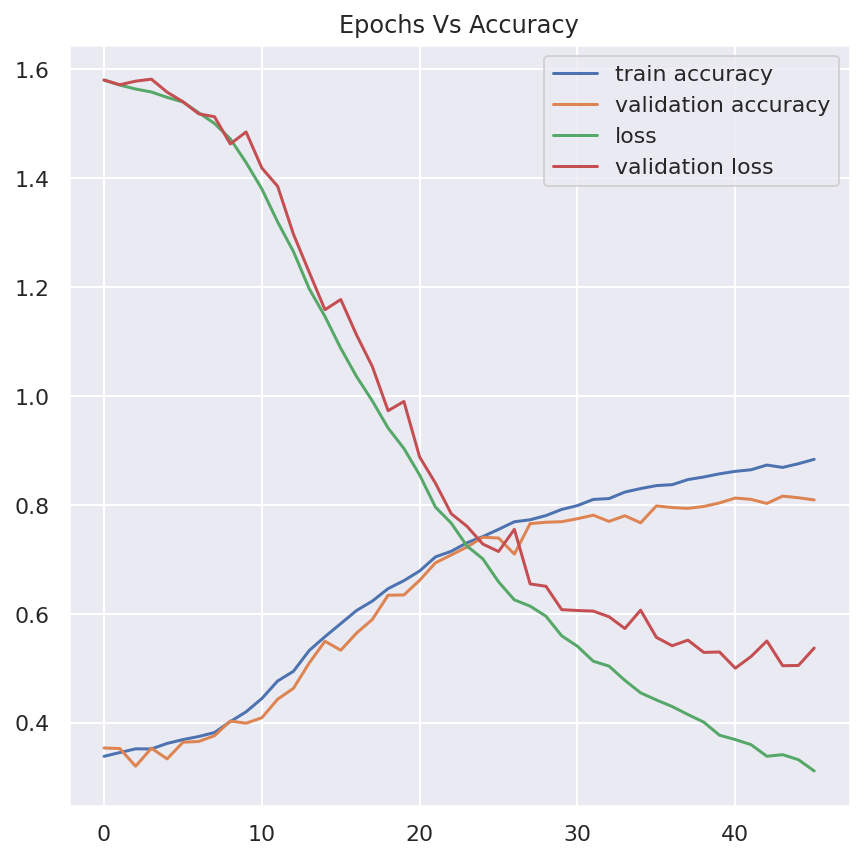

In [20]:
plt.rcParams["figure.figsize"] = (7,7)
plt.plot(history_embedding.history['accuracy'],label='train accuracy')
plt.plot(history_embedding.history['val_accuracy'],label='validation accuracy')
plt.plot(history_embedding.history['loss'],label='loss')
plt.plot(history_embedding.history['val_loss'],label='validation loss')
plt.legend(loc='upper right')
plt.title("Epochs Vs Accuracy")
plt.show()

# Model Evaluation and Comparision

In [21]:
model.evaluate(X_test_pad, y_test)

63/63 [==============================] - 5s 67ms/step - loss: 0.5331 - accuracy: 0.8100


[0.5330516695976257, 0.8100000023841858]

In [22]:
y_pred = np.argmax(model.predict(X_test_pad), axis  =  1)

63/63 [==============================] - 4s 58ms/step


In [23]:
y_true = np.argmax(y_test, axis = 1)

In [24]:
from sklearn import metrics
print(metrics.classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.85      0.83       695
           1       0.83      0.71      0.76       275
           2       0.67      0.68      0.67       159
           3       0.83      0.84      0.83       581
           4       0.82      0.92      0.87       224
           5       0.86      0.55      0.67        66

    accuracy                           0.81      2000
   macro avg       0.80      0.76      0.77      2000
weighted avg       0.81      0.81      0.81      2000



In [25]:
model.save('bi-lstm-bert_embedding_classification.h5')

In [47]:
# !gdown 1NNUIz8EWA9SfrXs0UbnmJ9N9-e28ot6R
# import tensorflow as tf

# model = tf.keras.models.load_model('bi-lstm-bert_embedding_classification.h5')

Downloading...
From: https://drive.google.com/uc?id=1NNUIz8EWA9SfrXs0UbnmJ9N9-e28ot6R
To: /content/bi-lstm-bert_embedding_classification.h5
100% 23.0M/23.0M [00:00<00:00, 276MB/s]


In [26]:
dictionary = {
    'joy' : 0,
    'anger' : 1,
    'love' : 2,
    'sadness' : 3,
    'fear' : 4,
    'surprise' : 5
    }

get_label = {val : key for key, val in dictionary.items()}
get_label

{0: 'joy', 1: 'anger', 2: 'love', 3: 'sadness', 4: 'fear', 5: 'surprise'}

In [27]:
def predict(sentence: str, model):
    get_label = {0: 'joy', 1: 'anger', 2: 'love', 3: 'sadness', 4: 'fear', 5: 'surprise'}
    sentence_lst=[]
    sentence_lst.append(sentence)
    sentence_seq = tokenizer.texts_to_sequences(sentence_lst)
    sentence_padded = pad_sequences(sentence_seq, maxlen=300, padding='post')    
    pred = get_label[np.argmax(model.predict(sentence_padded))]
    print(f'{sentence} : {pred}')

In [28]:
predict("i feel so threatened", model)

1/1 [==============================] - 0s 133ms/step
i feel so threatened : fear


In [29]:
tests = [
    'i am so lucky to get placed in my favourite company',
    'i hate that person. he is so rude to me for no reason',
    'i feel down. i could not cover the whole syllabus',
    'i feel so threatened',
    'to my utter surprise, he actually cleared the exam'
]

for e in tests:
    predict(e, model)

1/1 [==============================] - 0s 17ms/step
i am so lucky to get placed in my favourite company : joy
1/1 [==============================] - 0s 15ms/step
i hate that person. he is so rude to me for no reason : anger
1/1 [==============================] - 0s 16ms/step
i feel down. i could not cover the whole syllabus : sadness
1/1 [==============================] - 0s 14ms/step
i feel so threatened : fear
1/1 [==============================] - 0s 15ms/step
to my utter surprise, he actually cleared the exam : joy


In [30]:
def batch_predict(sentence: str, model):
    get_label = {0: 'joy', 1: 'anger', 2: 'love', 3: 'sadness', 4: 'fear', 5: 'surprise'}
    sentence_lst=[]
    sentence_lst.append(sentence)
    sentence_seq = tokenizer.texts_to_sequences(sentence_lst)
    sentence_padded = pad_sequences(sentence_seq, maxlen=300, padding='post')    
    pred = np.argmax(model.predict(sentence_padded, verbose=0))
    return pred

In [31]:
test_df_actual_labels = df_test.Sentiment.tolist()

In [32]:
test_df_inputs = df_test.Input.tolist()

In [33]:
test_preds = [batch_predict(i, model) for i in test_df_inputs]

In [34]:
get_label = {0: 'joy', 1: 'anger', 2: 'love', 3: 'sadness', 4: 'fear', 5: 'surprise'}
class_names = [get_label[i] for i in range(6)]

In [35]:
df_test_comparision_df = df_test.copy()
df_test_comparision_df

,Input,Sentiment
0,im feeling rather rotten so im not very ambiti...,3
1,im updating my blog because i feel shitty,3
2,i never make her separate from me because i do...,3
3,i left with my bouquet of red and yellow tulip...,0
4,i was feeling a little vain when i did this one,3
...,...,...
1995,i just keep feeling like someone is being unki...,1
1996,im feeling a little cranky negative after this...,1
1997,i feel that i am useful to my people and that ...,0
1998,im feeling more comfortable with derby i feel ...,0


In [36]:
df_test_comparision_df['predicted_sentiment'] = test_preds

In [37]:
df_test_comparision_df

,Input,Sentiment,predicted_sentiment
0,im feeling rather rotten so im not very ambiti...,3,3
1,im updating my blog because i feel shitty,3,3
2,i never make her separate from me because i do...,3,3
3,i left with my bouquet of red and yellow tulip...,0,0
4,i was feeling a little vain when i did this one,3,3
...,...,...,...
1995,i just keep feeling like someone is being unki...,1,1
1996,im feeling a little cranky negative after this...,1,1
1997,i feel that i am useful to my people and that ...,0,0
1998,im feeling more comfortable with derby i feel ...,0,0


In [38]:
length = len(df_test_comparision_df)
mis_matches_inputs = []
actual_mismatch = []
predicted_mismatch = []

for i in range(length):
    if df_test_comparision_df.loc[i, 'Sentiment'] != df_test_comparision_df.loc[i, 'predicted_sentiment']:
        mis_matches_inputs.append(df_test_comparision_df.iloc[i, 0])
        actual_mismatch.append(get_label[df_test_comparision_df.loc[i, 'Sentiment']])
        predicted_mismatch.append(get_label[df_test_comparision_df.loc[i, 'predicted_sentiment']])


mis_matches = pd.DataFrame(np.column_stack([mis_matches_inputs, actual_mismatch, predicted_mismatch]), 
                               columns=['Inputs', 'Actual', 'Predicted'])

mis_matches

,Inputs,Actual,Predicted
0,i explain why i clung to a relationship with a...,joy,sadness
1,i don t feel particularly agitated,fear,anger
2,i pay attention it deepens into a feeling of b...,fear,joy
3,i feel like my only role now would be to tear ...,sadness,joy
4,i feel just bcoz a fight we get mad to each ot...,anger,joy
...,...,...,...
375,i have no strong feelings for this book neithe...,anger,joy
376,i blunder through my life ignoring the pain wh...,sadness,joy
377,im able to refine my poses and concepts withou...,anger,joy
378,i came out of the airport that makes me feel i...,anger,fear


In [39]:
mis_matches.Actual.value_counts()

joy         106
sadness      94
anger        81
love         51
surprise     30
fear         18
Name: Actual, dtype: int64

In [40]:
mis_matches.Predicted.value_counts()

joy         138
sadness      99
love         54
fear         44
anger        39
surprise      6
Name: Predicted, dtype: int64

In [41]:
actual_inputs_dict = dict(mis_matches.Actual.value_counts())
predicted_output_dict = dict(mis_matches.Predicted.value_counts())

In [42]:
comparision = {}

for e in actual_inputs_dict:
    comparision[e] = predicted_output_dict[e] - actual_inputs_dict[e]
comparision

{'joy': 32, 'sadness': 5, 'anger': -42, 'love': 3, 'surprise': -24, 'fear': 26}

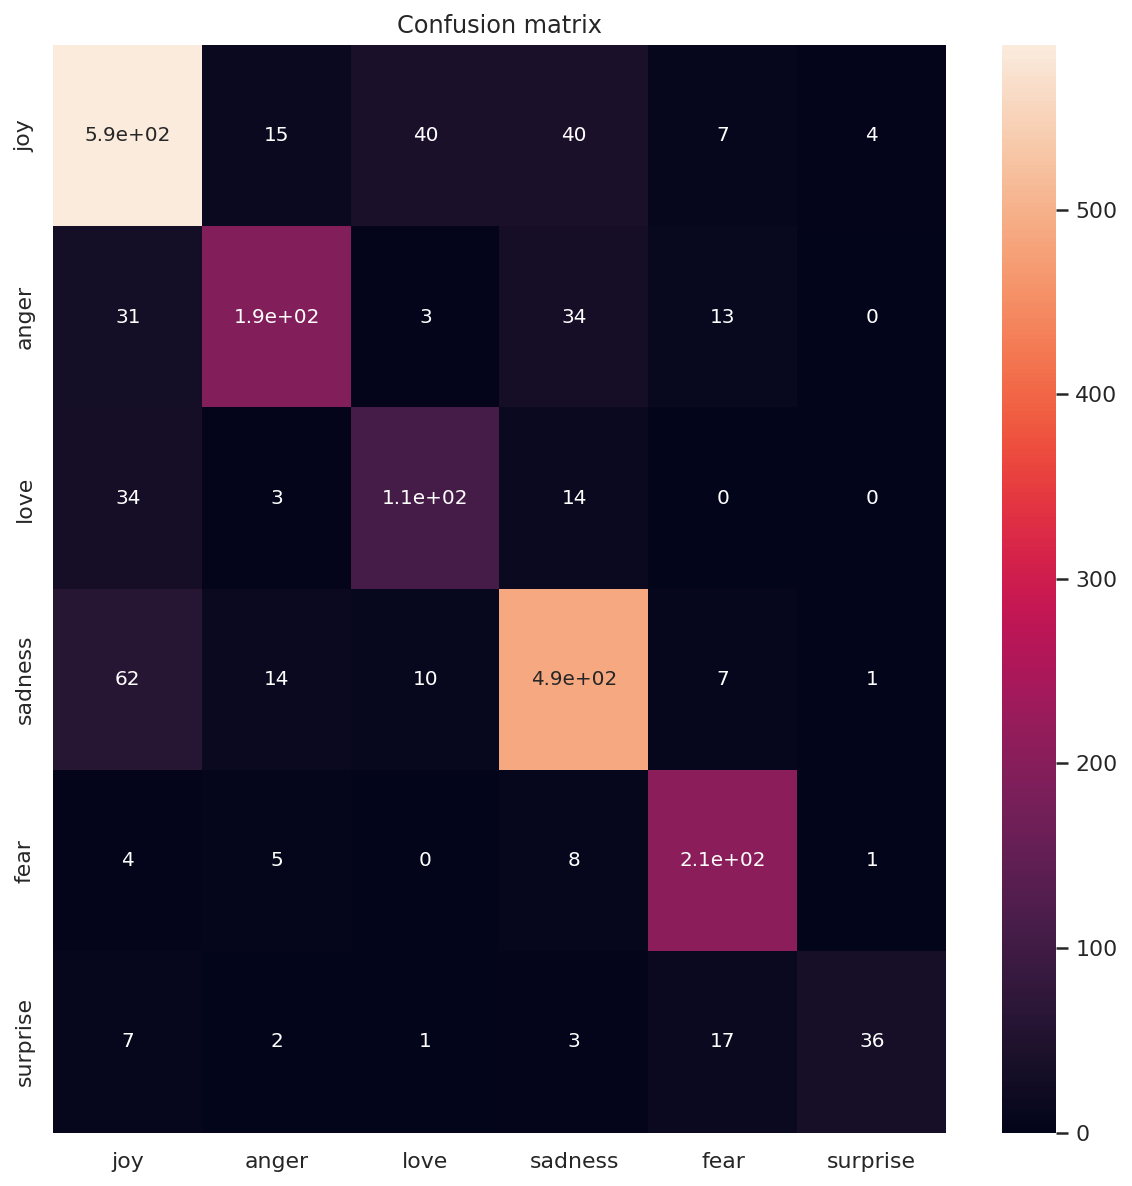

In [43]:
from sklearn.metrics import confusion_matrix

get_label = {0: 'joy', 1: 'anger', 2: 'love', 3: 'sadness', 4: 'fear', 5: 'surprise'}
class_names = get_label.values()

plt.rcParams["figure.figsize"] = (10,10)
CM = confusion_matrix(test_df_actual_labels, test_preds)
ax = plt.axes()
sns.heatmap(CM, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels=class_names, 
           yticklabels=class_names, ax = ax)
ax.set_title('Confusion matrix')
plt.show()

In [54]:
history_embedding.history['accuracy'][-1]

0.8835625052452087

In [55]:
history_embedding.history['val_accuracy'][-1]

0.8090000152587891